In [87]:
import numpy as np
import PyDSTool as dst
from PyDSTool.Toolbox import phaseplane as pp
from scipy.optimize import fsolve

In [33]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display, Math

In [20]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [47]:
mpl.rcParams['figure.figsize'] = [6, 4]
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8

In [5]:
dir = './figures/'
plt.rc('text', usetex=True)

# Carryover of a saddle-node bifurcation
# Application: gen activation model

The gen activation model is
$$
    \dot x = s - rx + \frac{x^{2}}{1+x^{2}},
$$
where
where $r>0$ is the degradation rate and $s\geq0$ is the activating signal (add references here in markdown syntax: Strogatz1994, Lewis1977).


## 1. Phase plane analysis

Steady states are given by
$$
\dot x = 0 \implies rx - s = \frac{x^2}{1+x^2}
$$

In [199]:
def f(x, s, r):
    return s - r*x + x**2/(1 + x**2)

def fprime(x, s, r):
    return -r + 2*x/(1 + x**2)**2

def plot_phaseportrait(s, r):
    # baseline
    xx = np.arange(0, 3, 0.01)
    plt.hlines(0, min(xx), max(xx), 'r')
    # arrows
    xx = np.arange(0, 3, 0.2)
    for x in xx:
        if f(x, s, r) < 0:
            plt.plot(x, 0, '<g')
        elif f(x, s, r) > 0:
            plt.plot(x, 0, '>g')
    # phase portrait
    xx = np.arange(0, 3, 0.01)
    yy = f(xx, s, r)
    plt.plot(xx, yy, 'b')
    # steady states
    xx = np.arange(0, 3, 0.1)
    for x in xx:
        ss = fsolve(f, x, (s, r), full_output=True)
        if ss[2] == 1:
            if fprime(ss[0], s, r) < 0:
                plt.plot(ss[0], 0, 'ob', ms=10)
            else:
                plt.plot(ss[0], 0, 'ob', ms=10, markerfacecolor='white')
    # plot specs
    plt.xlabel('$x$')
    plt.xlim((0., 2.))
    plt.ylabel('$\dot x$')
    plt.ylim((-0.1, 0.1))
    plt.show()

In [200]:
interact(plot_phaseportrait, 
         s=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.),
         r=widgets.FloatSlider(min=0, max=0.8, step=0.01, value=0.45));

interactive(children=(FloatSlider(value=0.0, description='s', max=0.2, step=0.01), FloatSlider(value=0.45, des…

Assuming the activating signal $s$ is zero and the activity of the is null, the gen, remains inactive.

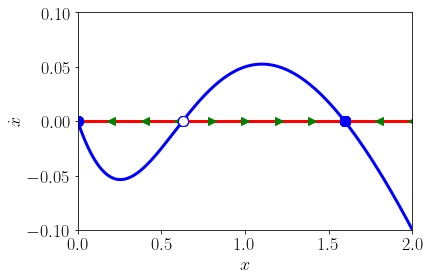

In [197]:
plot_phaseportrait(0.0, 0.45)

But if the activating signal increases above a threshold value $s^*$, the gene becomes active in via a critical transition and remains active even after the activating signal returns to zero.

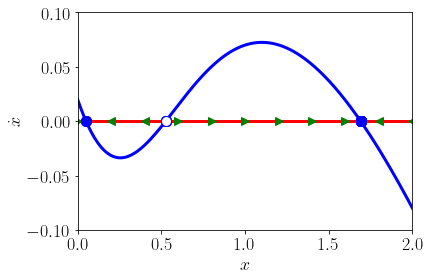

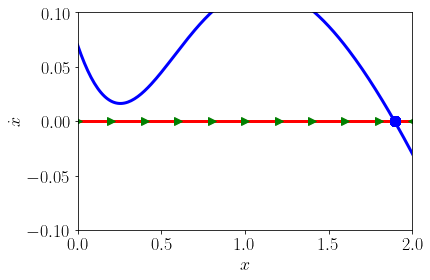

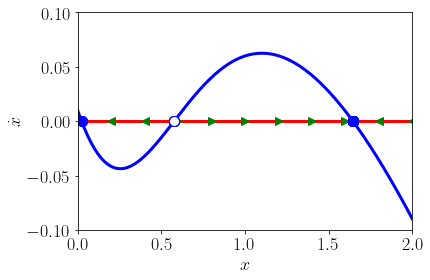

In [219]:
plot_phaseportrait(0.02, 0.45)
plt.savefig(dir + 'AppGenPhasePor.pdf', bbox_inches='tight')
plot_phaseportrait(0.07, 0.45)
plot_phaseportrait(0.01, 0.45)

## 2. Bifurcation diagram

We can construct the bifurcation diagram using continuation and the `PyDSTool` library of python.

In [300]:
# dynamical system
xstr = 's-r*x+x**2/(1+x**2)'
params = {'s': 0, 'r':0.5}
ics = {'x': 1}
DSargs = args(name='GenActivation')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'s': [0, 0.2], 'r': [0, 1.]}
DSargs.xdomain = {'x': [0, 2.0]}
DSargs.varspecs = {'x': xstr}
DSargs.ics = ics
DS = Generator.Vode_ODEsystem(DSargs)

In [301]:
# bifurcation diagram for s
PC = ContClass(DS)
name1 = 'EQ1'
PCargs = args(name=name1)
PCargs.type = 'EP-C'
PCargs.freepars = ['s']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 20
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()

Indeed there is a bifurcation point (`LP1`) at which a critical transition drives gen activation. The other bifucation point (`LP2`) occurs when $r=0.5$ (as can be found playing around with the phase plot above).

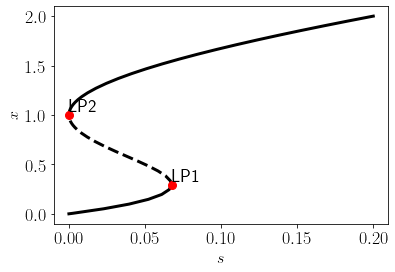

In [302]:
PC['EQ1'].display(('s', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.show()

The actual value of $s$ is

In [303]:
PC['EQ1'].getSpecialPoint('LP1')['s']

0.06744224886812158

From here we can follow the bifurcation point varying both parameters $s$ and $r$.

In [304]:
# Two-parameter bifurcation
namefold1 = 'F01'
PCargs = args(name=namefold1)
PCargs.type = 'LP-C'
PCargs.initpoint = 'EQ1:LP1'
PCargs.freepars = ['s', 'r']
PCargs.StepSize = 1e-2
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-4
PCargs.SaveEigen = True
PCargs.SaveJacobian = True
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 0
PC.newCurve(PCargs)
PC.curves[namefold1].forward()
PC.curves[namefold1].backward()

/home/shigoto/.local/lib/python3.8/site-packages/PyDSTool/PyCont/TestFunc.py:366: LinAlgWarning: Diagonal number 1 is exactly zero. Singular matrix.
  MLU = linalg.lu_factor(c_[r_[A,transpose(self.data.C)], r_[self.data.B,self.data.D]])


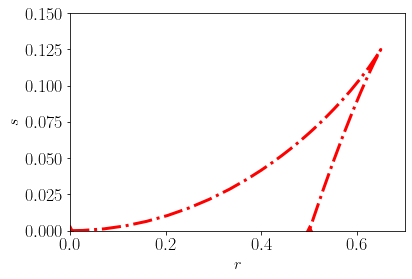

In [305]:
PC[namefold1].display(('r', 's'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P', 'BT', 'CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.7))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 0.15))
PC.plot.fig1.axes1.axes.set_ylabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(dir + 'AppGenTwoParBif.pdf', bbox_inches='tight')
plt.show()

The enclosed region corresponds to the region with 3 steady states.

In [306]:
PC['F01'].getSpecialPoint('CP1')

r:  0.6495190528409873
s:  0.12500000000153474
x:  0.5773502867198839
Labels: LP ({'data': args (
 V = {'x': 0.9999999999999982, 's': -2.9609096218494648e-08, 'r': -5.1308494490785326e-08},
 ds = 0.05,
 evals = [2.77555756e-11+0.j],
 evecs = [[1.]],
 jacx = [[2.77555756e-11]],
 jacp = [[ 1.         -0.57735029]]
), 'domain': 'inside', 'stab': 'N'})
Labels: CP ({'data': args (
 X = {'x': 0.5773502867198839, 's': 0.12500000000153474, 'r': 0.6495190528409873},
 V = {'x': 0.9999999999999982, 's': -2.9609096218494648e-08, 'r': -5.1308494490785326e-08},
 eigs = [2.77555756e-11+0.j]
), 'plot': No args defined, 'name': 'CP1'})

## 3. Turn $r$ into a variable

Suppose that we turn $r$ into a variable to get the system
$$
\begin{aligned}
    \dot x &= s - rx + \frac{x^{2}}{1+x^{2}}, \\
    \dot r &= a - br.
\end{aligned}
$$

According to the carryover theory, saddle-node bifurcation in the extended system would be a the intersection between the two-parameter bifurcation curve and the nullclines of $\dot r$ ($r=c=\frac{a}{b}$ in this case).

Consider $c=0.4$ and $c=0.6$.

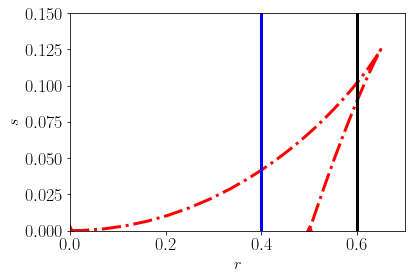

In [308]:
PC[namefold1].display(('r', 's'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','BT','CP'])
PC.plot.fig1.axes1.axes.set_xlim((0.0, 0.7))
PC.plot.fig1.axes1.axes.set_xlabel('$r$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((0.0, 0.15))
PC.plot.fig1.axes1.axes.set_ylabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.axvline(x=0.4, lw=3, color='b')
plt.axvline(x=0.6, lw=3, color='k')
# plt.savefig(dir + 'AppGenTwoParBif.pdf', bbox_inches='tight')
plt.show()

In [309]:
# dynamical system
xstr = 's-r*x+x**2/(1+x**2)'
rstr = 'a-b*r'
params = {'s': 0, 'a': 0.4, 'b': 1}
ics = {'x': 1, 'r': 0.5}
DSargs = args(name='GenActivation')
DSargs.pars = params
DSargs.tdata = [0, 2]
DSargs.pdomain = {'s': [0, 0.2]}
DSargs.xdomain = {'x': [0, 2.0], 'r': [0, 1.]}
DSargs.varspecs = {'x': xstr, 'r': rstr}
DSargs.ics = ics
DS = Generator.Vode_ODEsystem(DSargs)

In [310]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'r': 0.4, 'x': 0.0},
 {'r': 0.4, 'x': 0.5},
 {'r': 0.4, 'x': 1.9999999999999998})

In [320]:
PC = ContClass(DS)
name1 = 'EQ1'
PCargs = args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 0, 'r': 0.4}
PCargs.freepars = ['s']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
# PC.curves[name1].backward()
PC.curves[name1].forward()


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
r  =  0.4
x  =  0.21978974063735832
s  =  0.041834447154491076

Eigenvalues = 

     (0.000000,0.000000)
     (-1.000000,0.000000)


a = 0.742231389160193

B Point found 
0 : 
r  =  0.4
x  =  0.5000000515592112
s  =  -1.2374211055411448e-08



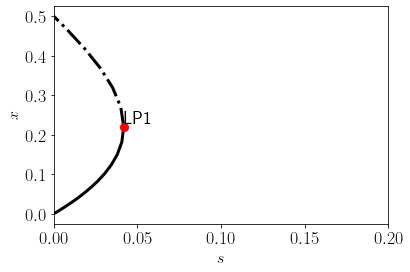

In [322]:
PC['EQ1'].display(('s', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((0, 0.2))
PC.plot.fig1.axes1.axes.set_xlabel('$s$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
# plt.savefig(dir + 'Example1Case2.pdf', bbox_inches='tight')
plt.show()

## $N$-dimensional case

### Example 3
$$x'=\mu-x^2+xy-xy^2$$
$$y'=\lambda-y-x^2+yx^2$$

In [24]:
xstr = 'mu - x**2 + x*y - x*y**2'
ystr = 'lambda -  y - x**2 + y*x**2'
params = {'mu': 0.1, 'lambda':0}
ics = {'x': 0.1, 'y': 0.1}
DSargs = args(name='EX3')
DSargs.pars = params
DSargs.tdata = [0, 10]
DSargs.pdomain = {'mu': [-4, 4], 'lambda': [-4, 4]}
DSargs.xdomain = {'x': [-1e4, 1e4], 'y': [-1e4, 1e4]}
DSargs.varspecs = {'x': xstr, 'y': ystr}
DSargs.ics = ics
DS = Generator.Vode_ODEsystem(DSargs)

In [25]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'x': 0.27504269322489472, 'y': -0.081839518530518768},
 {'x': -1.5011072448495351, 'y': 1.7978789438024105})

In [26]:
PC = ContClass(DS)
name1 = 'EQ1'
PCargs = args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': 0.27504269322489472, 'y': -0.081839518530518768}
PCargs.freepars = ['mu']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000001
  |transpose(A)p| = 0.000001

LP Point found 
0 : 
y  =  -1.00455109823e-13
x  =  -3.16946540954e-07
mu  =  1.00455077984e-13

Eigenvalues = 

     (0.000001,0.000000)
     (-1.000000,0.000000)


a = 0.99999904916097981


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000001

LP Point found 
0 : 
y  =  -0.177774348898
x  =  -0.388511163739
mu  =  0.0695952074802

Eigenvalues = 

     (-0.000000,0.000000)
     (-0.281415,0.000000)


a = 4.4374653707739897

B Point found 
0 : 
y  =  -1.94626947259
x  =  -0.812765484811
mu  =  -4.00000001401

B Point found 
0 : 
y  =  -1.63137182301
x  =  0.787381793598
mu  =  4.0000000141



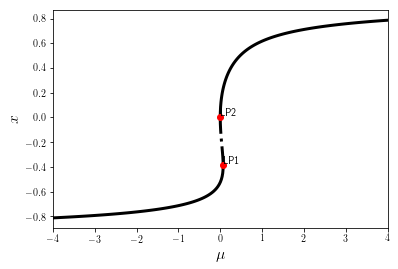

In [27]:
PC['EQ1'].display(('mu', 'x'), stability=True, linewidth=3)
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((-4, 4))
PC.plot.fig1.axes1.axes.set_xlabel('$\mu$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
# plt.savefig(dir + 'Example1Case2.pdf', bbox_inches='tight')
plt.show()

In [28]:
# Two-parameter bifurcation
namefold1 = 'F01'
PCargs = args(name=namefold1)
PCargs.type = 'LP-C'
PCargs.initpoint = 'EQ1:LP2'
PCargs.freepars = ['lambda', 'mu']
PCargs.StepSize = 1e-2
PCargs.MaxNumPoints = 200
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-4
PCargs.SaveEigen = True
PCargs.SaveJacobian = True
PCargs.LocBifPoints = 'all'
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2
PC.newCurve(PCargs)

PC.curves[namefold1].forward()


Checking...
  |a| = -0.746381


CP Point found 
0 : 
y  =  1.37736196558
x  =  -0.355951709688
mu  =  -0.0583092714415
lambda  =  1.32954959335

Eigenvalues = 

     (-0.000000,0.000000)
     (-0.681159,0.000000)



Checking...
  <b,c> = 0.000000


BT Point found 
0 : 
y  =  1.36914567374
x  =  -0.58285001674
mu  =  0.0451334658126
lambda  =  1.24374166791

Eigenvalues = 

     (0.000011,0.000000)
     (-0.000011,0.000000)



Checking...
  |a| = -1.173862


CP Point found 
0 : 
y  =  0.672520604858
x  =  -1.05245265297
mu  =  1.33944522374
lambda  =  1.03525531391

Eigenvalues = 

     (2.432799,0.000000)
     (0.000000,0.000000)



Checking...
  <b,c> = -0.000000


BT Point found 
0 : 
y  =  -0.129280244349
x  =  -0.464921021285
mu  =  0.148276050365
lambda  =  0.114815437664

Eigenvalues = 

     (0.000001,0.000000)
     (-0.000001,0.000000)


Test function going crazy:  <PyDSTool.PyCont.TestFunc.CP_Fold object at 0x7f0b7e1e8390> 


Checking...
  |a| = -0.662563


CP Point found 
0 

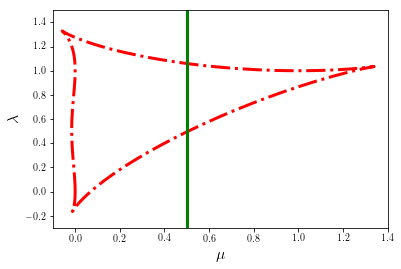

In [29]:
PC[namefold1].display(('mu', 'lambda'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','BT','CP'])
PC.plot.fig1.axes1.axes.set_xlim((-0.1, 1.4))
PC.plot.fig1.axes1.axes.set_xlabel('$\mu$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylim((-0.3, 1.5))
PC.plot.fig1.axes1.axes.set_ylabel('$\lambda$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.axvline(x=0.5, lw=3, color='g')
plt.savefig(dir + 'Example3TwoParBif.pdf', bbox_inches='tight')
plt.show()

**Extended system**

In [30]:
xstr = 'mu - x**2 + x*y - x*y**2'
ystr = 'lambda -  y - x**2 + y*x**2'
mustr = 'mu - 0.5'
params = {'lambda':0.5}
ics = {'x': 0.1, 'y': 0.1, 'mu': 0.6}
DSargs = args(name='EX32')
DSargs.pars = params
DSargs.tdata = [0, 10]
DSargs.pdomain = {'lambda': [0, 1.5]}
DSargs.xdomain = {'x': [-1e4, 1e4], 'y': [-1e4, 1e4], 'mu': [-4, 4]}
DSargs.varspecs = {'x': xstr, 'y': ystr, 'mu': mustr}
DSargs.ics = ics
DS = Generator.Vode_ODEsystem(DSargs)

In [31]:
fps = pp.find_fixedpoints(DS, n=4, eps=1e-8)
fps

({'mu': 0.5, 'x': -0.6542548769595159, 'y': 0.12579855937382364},
 {'mu': 0.5, 'x': 0.70710678118647341, 'y': 5.7000696238307165e-14},
 {'mu': 0.5, 'x': -0.70710678118654724, 'y': 4.9590562512261009e-16},
 {'mu': 0.5, 'x': -1.3496175169788096, 'y': 1.6086668495344683})

In [32]:
PC = ContClass(DS)
name1 = 'EQ1'
PCargs = args(name=name1)
PCargs.type = 'EP-C'
PCargs.initpoint = {'x': -0.70710678118647341, 'y': 0.0, 'mu': 0.5}
PCargs.freepars = ['lambda']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 5e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']
PCargs.verbosity = 2

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()

B Point found 
0 : 
mu  =  0.5
x  =  -1.15599641532
y  =  -0.486645388438
lambda  =  1.5000000424


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000001
  |transpose(A)p| = 0.000002

LP Point found 
0 : 
mu  =  0.5
x  =  -0.679284141038
y  =  0.0604375599575
lambda  =  0.493976985613

Eigenvalues = 

     (-0.000001,0.000000)
     (0.876781,0.000000)
     (1.000000,0.000000)


a = 2.2712126763675275


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
mu  =  0.5
x  =  -0.842918545643
y  =  1.20692391392
lambda  =  1.05990205733

Eigenvalues = 

     (0.000000,0.000000)
     (1.146607,0.000000)
     (1.000000,0.000000)


a = 1.7965472532180888

B Point found 
0 : 
mu  =  0.5
x  =  -1.54880632376
y  =  1.71489796418
lambda  =  -7.58444257289e-09



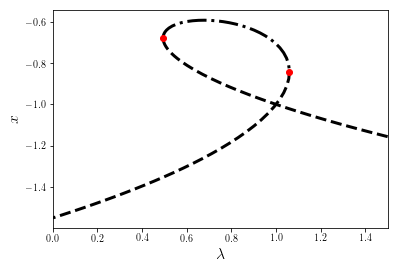

In [33]:
PC['EQ1'].display(('lambda', 'x'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((0, 1.5))
PC.plot.fig1.axes1.axes.set_xlabel('$\lambda$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylabel('$x$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(dir + 'Example3ExtSysBifX.pdf', bbox_inches='tight')
plt.show()

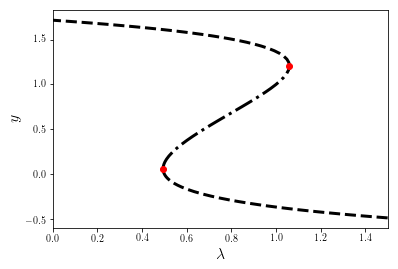

In [34]:
PC['EQ1'].display(('lambda', 'y'), stability=True, linewidth=3)
PC.plot.toggleLabels('off')
PC.plot.fig1.toggleAll('off', bytype=['P','B'])
PC.plot.fig1.axes1.axes.set_xlim((0, 1.5))
PC.plot.fig1.axes1.axes.set_xlabel('$\lambda$', fontsize=16)
PC.plot.fig1.axes1.axes.set_ylabel('$y$', fontsize=16)
PC.plot.fig1.axes1.axes.set_title('')
plt.savefig(dir + 'Example3ExtSysBifY.pdf', bbox_inches='tight')
plt.show()